# Import Libraries

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Preprocess

In [2]:
# Get the preprocessed X and y from the data.
def get_X_y():
    # Read in data.
    df = pd.read_csv('data/Boats_Cleaned_dataset.csv')
    df = df.fillna(0)

    # Delete selected rows with NaN.
    df = df[pd.to_numeric(df['zip'], errors='coerce').notnull()]
    df['zip'] = df['zip'].astype(int)
    df = df.drop(df[df['zip']==0].index)
    df = df.drop(df[df['engineCategory']==0].index)
    df = df.drop(df[df['beam_ft']==0].index)
    df = df.drop(df[df['totalHP']==0].index)

    # Delete selected columns with NaN
    df = df.drop(['Unnamed: 0','created_date','id','maxEngineYear','minEngineYear','dryWeight_lb', 'make', 'model','city','sellerId'],axis=1)

    # Define features and target.
    X0 = df.drop(['price'], axis=1)
    y0 = df.price

    # Standardize
    X_n = X0.select_dtypes(include='number')
    X_c = X0.select_dtypes(exclude='number')
    scaler = StandardScaler()
    X_n = scaler.set_output(transform='pandas').fit_transform(X_n)

    # Hot Encode
    X_c = pd.get_dummies(X_c, drop_first = False) #dropped first
    df = pd.concat([X_n,X_c,y0],axis=1)

    # Redefine features and target
    X = df.drop(['price'],axis=1)
    y = df.price

    return (X, y, scaler)

In [3]:
X, y, scaler = get_X_y()
print(X.shape)

(5752, 142)


# Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Feature Engineer, d=2

In [5]:
poly = PolynomialFeatures(2,interaction_only=False,include_bias=False)
Xe_train = poly.fit_transform(X_train)
cols = poly.get_feature_names_out(X_train.columns)
Xe_train = pd.DataFrame(Xe_train, columns=cols)
# Xe_train = stnd.fit_transform(Xe_train)
Xe_train['bias'] = 1
print(Xe_train.shape)
Xe_train.head()

Xe_test = poly.fit_transform(X_test)
cols = poly.get_feature_names_out(X_test.columns)
Xe_test = pd.DataFrame(Xe_test, columns=cols)
# Xe_test = stnd.transform(Xe_test)
Xe_test['bias'] = 1
Xe_test.head()

(4601, 10296)


,year,length_ft,beam_ft,numEngines,totalHP,zip,created_month,created_year,type_power,type_sail,...,state_VT state_WA,state_VT state_WI,state_VT state_WV,state_WA^2,state_WA state_WI,state_WA state_WV,state_WI^2,state_WI state_WV,state_WV^2,bias
0,0.459450,0.367392,-0.046988,-0.384248,-0.022364,0.016842,-0.624789,0.669243,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.050196,-0.588427,-0.278693,-0.384248,-0.349689,-1.443551,1.187661,-0.442682,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.357137,-0.800832,-0.697436,-0.384248,-0.677015,-1.698533,0.885586,-1.554608,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.357137,-0.800832,-0.069321,-0.384248,-0.563162,0.924080,1.791810,-2.666533,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.459450,-0.269821,-0.094445,1.745032,0.973844,-0.594695,1.791810,-0.442682,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Use Lasso for feature selection

In [7]:
# regularize
grid = {'alpha':[390]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
# lassoCV = cross_validate(lasso, return_train_score=True)
lassoCV.fit(Xe_train,y_train)

print()
print('best alpha =',lassoCV.best_params_, '  valid R2 =',lassoCV.best_score_.round(3))

C:\Users\mirandm1\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+11, tolerance: 1.426e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\mirandm1\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.939e+10, tolerance: 1.330e+10
  model = cd_fast.enet_coordinate_descent(



best alpha = {'alpha': 390}   valid R2 = 0.803


C:\Users\mirandm1\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e+10, tolerance: 1.707e+10
  model = cd_fast.enet_coordinate_descent(


# Show alpha optimization

length_ft boatClass_power-house           -72589.201454
totalHP state_OH                          -40400.604071
length_ft hullMaterial_aluminum           -31394.376608
totalHP boatClass_power-expresscruiser    -28118.409778
year boatClass_power-highperf             -19820.430516
                                              ...      
length_ft                                  58307.088272
totalHP boatClass_power-mega               62066.984276
totalHP boatClass_power-pilot              67923.304265
year totalHP                               70016.246072
condition_new fuelType_diesel             337539.533625
Length: 10296, dtype: float64

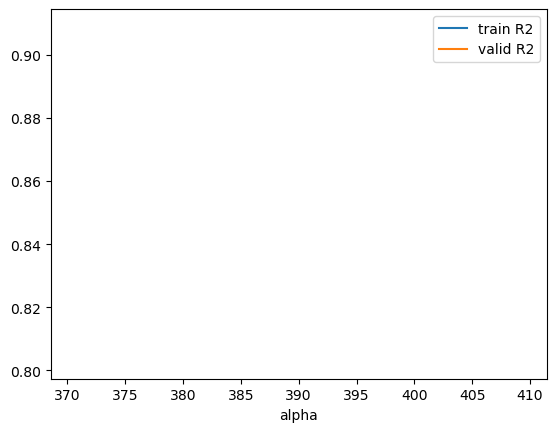

In [8]:
results = pd.DataFrame()
results['alpha'] = (grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['valid R2']  = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index=Xe_train.columns)
coef.sort_values()

# Lasso test R2

In [9]:
print('Test R2: ', lassoCV.score(Xe_test,y_test))

Test R2:  0.8933933404661998


# Use lasso to remove some features

In [11]:
filtered_coef = coef.drop(coef[coef.apply(lambda x: (x < 0.0001) & (x > -0.0001))].index)
filtered_coef

year                                                  19497.090073
length_ft                                             58307.088272
numEngines                                            10739.325052
totalHP                                               30681.331832
year^2                                                13751.826602
                                                         ...      
condition_new fuelType_0                              -2545.380369
condition_new fuelType_diesel                        337539.533625
condition_new engineCategory_outboard                 -5902.681414
fuelType_0 engineCategory_outboard                     -494.336627
fuelType_gasoline engineCategory_inboard-outboard     -1211.686351
Length: 105, dtype: float64

# Optimize N Estimators random forest for this set

In [ ]:
grid = {'n_estimators':[250, 500, 1000, 2000, 4000]}

rf = RandomForestRegressor(max_features = 1/3, max_depth=35)
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(Xe_train[filtered_coef.index.to_list()],y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_.round(3))

# Show optimization

In [ ]:
print('Random Forest Regressor')
print('     Optimal Parameters:', rfCV.best_params_)
print('     Optimal Valid R2:', rfCV.cv_results_['mean_test_score'])
results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
results.plot.line(x='trees',y=['train R2','valid R2'])

# Calculate and Show test R2

In [12]:
# out-of-bag score
rf = RandomForestRegressor(n_estimators=1000, max_depth=35, max_features = 1/3,oob_score=True)
rf.fit(Xe_train[filtered_coef.index.to_list()],y_train)
print('out-of-bag R2 =',rf.oob_score_.round(3))
print()
cv_results = cross_validate(rf,Xe_train[filtered_coef.index.to_list()],y_train,return_train_score=True)
R2_trainCV = cv_results['train_score'].mean()
R2_valid   = cv_results['test_score'].mean()
print('train R2 (CV) =',R2_trainCV.round(3),'  valid R2 =',R2_valid.round(3))
print()
R2_train = rf.score(Xe_train[filtered_coef.index.to_list()],y_train)
R2_test  = rf.score(Xe_test[filtered_coef.index.to_list()],y_test)
print('     train R2 =',R2_train.round(3),'    test R2 =',R2_test.round(3))

out-of-bag R2 = 0.844

train R2 (CV) = 0.977   valid R2 = 0.836

     train R2 = 0.979     test R2 = 0.934


In [51]:
deviations = []
predictions = []

for j in np.arange(0,len(Xe_test)):
    predictions.append(rf.predict(Xe_test[filtered_coef.index.to_list()].iloc[[j]])[0])
    deviations.append(np.abs( y_test.iloc[j]-predictions[j]))

In [52]:
idxMax = np.argmax(deviations)
idxMin =np.argmin(deviations)
print(idxMax, deviations[idxMax],predictions[idxMax],y_test.iloc[idxMax])
print(idxMin, deviations[idxMin],predictions[idxMin],y_test.iloc[idxMin])

463 1057946.824 2342053.176 3400000.0
659 0.4570833333309565 22004.54291666667 22005.0


In [53]:
sorted(deviations, key = lambda x:float(x))

[0.4570833333309565,
 2.3140000000003056,
 3.8400000000001455,
 4.084999999999127,
 6.81000000000131,
 8.255000000001019,
 8.375741587202356,
 12.030946428571042,
 12.609000000000378,
 16.309079365081743,
 17.56499999999869,
 19.12765716373906,
 22.52541666666366,
 24.770000000000437,
 26.6299999999992,
 26.91400000000067,
 30.22400000000016,
 32.37985652607313,
 33.12991666666494,
 33.864888888887435,
 38.13358974359289,
 39.31900000000314,
 39.652980952385406,
 39.87811111111114,
 43.77399999999761,
 47.01499999999942,
 48.49981858961837,
 49.02100000000064,
 49.474999999998545,
 50.65299999999843,
 51.06016666666983,
 54.757083333337505,
 55.35200000000077,
 57.33188070021788,
 59.54359283559825,
 60.780968137252785,
 61.99069444444467,
 62.64202164501876,
 63.07111904761405,
 64.4444999999996,
 65.02599999999984,
 66.34499999999935,
 73.5674393939371,
 75.29374999999709,
 76.31053113556845,
 82.13885714285425,
 82.77576495726316,
 83.01499999999942,
 83.90999999999985,
 83.98399999

ValueError: `bins` must increase monotonically, when an array

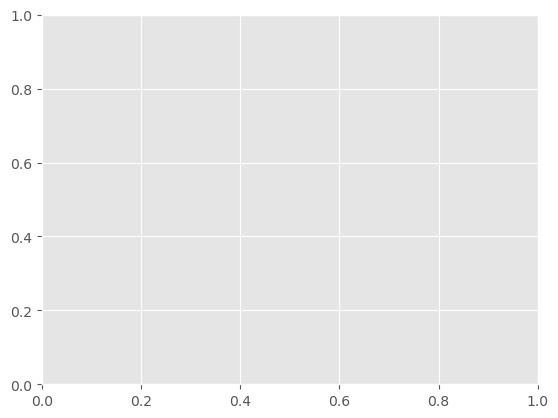

In [59]:
plt.scatter(y_test, sales_per_day)
plt.show()

In [58]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
pd.plotting.scatter_matrix([y_test, deviations],figsize=(12,12))


AttributeError: 'list' object has no attribute '_get_numeric_data'

In [ ]:
len(deviations)

In [ ]:
deviations[576]

In [ ]:
ind = Xe_train[Xe_train['boatClass_power-house']==1.0].index
ind

In [ ]:
Xe_test.boatClass

In [ ]:
Xe_test['boatClass']

In [ ]:
Xe_test.head()

In [13]:
Xe_train[Xe_train['boatClass_power-house']==1.00].index

Index([ 103,  235,  300,  373,  798,  953, 1322, 2047, 2150, 2171, 2256, 2357,
       2772, 3173, 3339, 3521, 3733, 3826, 4002, 4344, 4385],
      dtype='int64')

In [43]:
print(rf.predict(Xe_train[filtered_coef.index.to_list()].iloc[[4385]])[0])
print((y_train.iloc[[4385]]))


850007.859
12561    895000.0
Name: price, dtype: float64


In [49]:
deviationsTrain = []
predictionsTrain = []

for j in np.arange(0,len(Xe_train)):
    predictionsTrain.append(rfCV.predict(Xe_train[filtered_coef.index.to_list()].iloc[[j]])[0])
    deviationsTrain.append(np.abs( y_train.iloc[j]-predictionsTrain[j]))

NameError: name 'rfCV' is not defined

In [48]:
y_train.iloc[103]-predictionsTrain[103]

NameError: name 'predictionsTrain' is not defined

In [ ]:
y_train[103]

In [25]:
Xe_train.iloc[[373]]

,year,length_ft,beam_ft,numEngines,totalHP,zip,created_month,created_year,type_power,type_sail,...,state_VT state_WA,state_VT state_WI,state_VT state_WV,state_WA^2,state_WA state_WI,state_WA state_WV,state_WI^2,state_WI state_WV,state_WV^2,bias
373,-0.870625,2.81004,1.488406,1.745032,1.059233,0.645877,-0.624789,-7.114234,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
X_n = Xe_train[scaler.feature_names_in_]
unScaled = scaler.inverse_transform(X_n)
unScaled

In [26]:
X_n = X_train.select_dtypes(include='number')
unScaled = scaler.inverse_transform(X_n)
unScaled

array([[2.0190e+03, 1.9420e+01, 8.5000e+00, ..., 4.6060e+04, 8.0000e+00,
        2.0180e+03],
       [2.0190e+03, 1.9330e+01, 7.8300e+00, ..., 3.2317e+04, 8.0000e+00,
        2.0180e+03],
       [2.0190e+03, 1.8800e+01, 8.1700e+00, ..., 3.3170e+04, 1.2000e+01,
        2.0180e+03],
       ...,
       [2.0190e+03, 1.9000e+01, 8.5000e+00, ..., 5.3821e+04, 1.0000e+00,
        2.0190e+03],
       [2.0190e+03, 1.1000e+01, 4.0000e+00, ..., 6.2712e+04, 3.0000e+00,
        2.0190e+03],
       [2.0190e+03, 1.7580e+01, 8.0800e+00, ..., 3.1060e+03, 1.0000e+00,
        2.0190e+03]])

In [44]:
unScaled[4385]

array([2.0180e+03, 4.8000e+01, 1.7670e+01, 2.0000e+00, 6.6000e+02,
       3.3301e+04, 1.1000e+01, 2.0180e+03])

In [45]:
y_train.iloc[103]

379995.0

In [47]:
rf.predict(Xe_train[filtered_coef.index.to_list()].iloc[[103]])[0]

526195.792

In [ ]:
y_test[y_test==2495000.00].index

In [46]:
unScaled[103]

array([2.0170e+03, 8.4000e+01, 1.6000e+01, 2.0000e+00, 5.0000e+02,
       4.2544e+04, 6.0000e+00, 2.0180e+03])

In [ ]:
Xe_train.iloc[228]

In [ ]:
rf.predict(Xe_train[filtered_coef.index.to_list()].iloc[[228]])[0]

In [ ]:
y_test[y_test==25430.0].index

In [ ]:
unScaled[1085]

In [ ]:
y_test.iloc[1085]

In [ ]:
y_test.iloc[idxMax]